# CNN

In [38]:
import time

import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np

import os, sys

import utils

from train import train

from best_utils import *
from cross_validation import cross_validation
import image_preprocessing

from skimage import color

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'

In [40]:
PATCH_SIZE = 8

In [41]:
# Read images, change to hsv, saturate and stack into a tensor
files = os.listdir(IMAGE_DIR)
imgs = np.stack([image_preprocessing.saturate_hsv_img(color.rgb2hsv(load_image(IMAGE_DIR + file))) for file in files]) # images (400, 400, 3)

# Read groundtruts into a tensor and threshold their values
GT_DIR = ROOT_DIR + 'groundtruth/'
gt_imgs = np.stack([crop_groundtruth(load_image(GT_DIR + file)) for file in files]) # images (400, 400)

In [42]:
# Patch images and groundtruths
patched_imgs = np.stack([patch_image(im, PATCH_SIZE) for im in imgs])
patched_gts = np.stack([patch_groundtruth(gt, PATCH_SIZE) for gt in gt_imgs])

In [43]:
N = 5 # Number of image to be used in training

In [44]:
KERNEL_SIZE = 3
KERNEL_RADIUS = (KERNEL_SIZE - 1) // 2

In [45]:
X = torch.from_numpy(np.stack(patched_imgs[:N])).type(torch.FloatTensor)
Y = torch.from_numpy(np.ravel(np.stack([drop_external_layers(g, KERNEL_RADIUS) for g in patched_gts[:N]]))).type(torch.LongTensor)

In [46]:
cnn = nn.Sequential(
    NWHCtoNCWH(),
    nn.Conv2d(3, 27, (KERNEL_SIZE, KERNEL_SIZE)),
    nn.Sigmoid(),
    NCWHtoNWHC(),
    nn.Linear(27, 2),
    nn.Tanh(),
    Threshold(0)
)

In [47]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.05)
costf = torch.nn.CrossEntropyLoss()
start = time.perf_counter()
train(X, Y, cnn, costf, optimizer, 10000, 1000)
print(time.perf_counter() - start)

Epoch [1/10000], Loss: 0.6926
Epoch [1001/10000], Loss: 0.3135
Epoch [2001/10000], Loss: 0.2787
Epoch [3001/10000], Loss: 0.2682
Epoch [4001/10000], Loss: 0.2605
Epoch [5001/10000], Loss: 0.2537
Epoch [6001/10000], Loss: 0.2487
Epoch [7001/10000], Loss: 0.2450
Epoch [8001/10000], Loss: 0.2406
Epoch [9001/10000], Loss: 0.2384
113.6875842590016


array([-1.,  1.], dtype=float32)

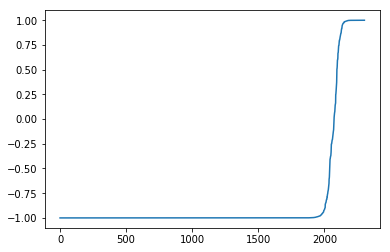

In [48]:
i = 12
x_test = np.expand_dims(patched_imgs[i], axis=0)

x_test = torch.from_numpy(x_test).type(torch.FloatTensor)

preds = cnn(Variable(x_test))

preds = preds.data.numpy()[:, 1]

preds = np.squeeze(preds)

preds = np.reshape(preds, (48, 48))

#plt.figure(figsize=(10,10))
#plt.imshow(preds, cmap='Greys_r')

plt.plot(np.sort(np.ravel(preds)))

preds[preds <= 0] = -1
preds[preds > 0] = 1

#plt.plot(np.sort(np.ravel(preds)))
np.unique(preds)

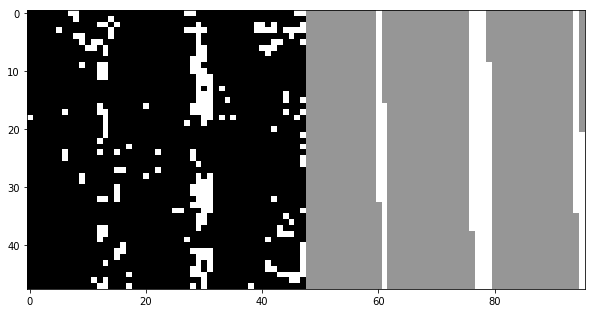

In [49]:
ori = drop_external_layers(patched_gts[i], 1)

plt.figure(figsize=(10,10))
plt.imshow(np.hstack([preds, ori]), cmap='Greys_r')